In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import spacy

from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [2]:
EMOTION_LABEL = {
    "anger": 0,
    "joy": 1,
    "optimism": 2,
    "sadness": 3
}

class EmotionDataset(Dataset):

    def __init__(self, training):
        spacy.prefer_gpu()
        self.nlp = spacy.load("en_core_web_sm")
        self.data = None

        if training:
            self.path_text   = "./data/tweeteval/emotion/train_text.txt"
            self.path_labels = "./data/tweeteval/emotion/train_labels.txt"
        else:
            self.path_text   = "./data/tweeteval/emotion/test_text.txt"
            self.path_labels = "./data/tweeteval/emotion/test_labels.txt"

        self.data   = self._load_txt_file(self.path_text)
        self.labels = self._load_txt_file(self.path_labels, perform_nlp=False)

    def _load_txt_file(self, path, perform_nlp=True):

        with open(path, "r") as f:
            lines = f.readlines()

            print(f"Loading {path} with {len(lines)} lines")

            for i in range(len(lines)):
                if i % 500 == 0:
                    print(f"Processing line {i}/{len(lines)}")

                lines[i] = lines[i].strip()
                lines[i] = lines[i].replace("\n", "")

                if perform_nlp:
                    lines[i] = self.nlp(lines[i])

            return lines

    def __getitem__(self, index):
        return (self.data[index], int(self.labels[index]))

    def __len__(self):
        return len(self.data)

train_dataset = EmotionDataset(training=True)
test_dataset  = EmotionDataset(training=False)

Loading ./data/tweeteval/emotion/train_text.txt with 3257 lines
Processing line 0/3257
Processing line 500/3257
Processing line 1000/3257
Processing line 1500/3257
Processing line 2000/3257
Processing line 2500/3257
Processing line 3000/3257
Loading ./data/tweeteval/emotion/train_labels.txt with 3257 lines
Processing line 0/3257
Processing line 500/3257
Processing line 1000/3257
Processing line 1500/3257
Processing line 2000/3257
Processing line 2500/3257
Processing line 3000/3257
Loading ./data/tweeteval/emotion/test_text.txt with 1421 lines
Processing line 0/1421
Processing line 500/1421
Processing line 1000/1421
Loading ./data/tweeteval/emotion/test_labels.txt with 1421 lines
Processing line 0/1421
Processing line 500/1421
Processing line 1000/1421


In [3]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim=128, hidden_dim=256, vocab_size=5001, tagset_size=4):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim * 85, tagset_size)

        self.embedding_dim = embedding_dim

    def forward(self, sentence):
        batch_size = len(sentence)
        embeds = self.word_embeddings(sentence)
        embeds = nn.utils.rnn.pack_padded_sequence(embeds, [85 for i in range(sentence.shape[0])], batch_first=True)
        lstm_out, _ = self.lstm(embeds)
        out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        out_unpacked = out_unpacked.reshape(batch_size, -1)
        tag_space = self.hidden2tag(out_unpacked)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [4]:
class GRUTagger(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=256, vocab_size=5001, tagset_size=4):
        super(GRUTagger, self).__init__()
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn             = nn.GRU(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim * 85, tagset_size)

    def forward(self, sentence):
        batch_size = len(sentence)
        embeds = self.word_embeddings(sentence)
        embeds = nn.utils.rnn.pack_padded_sequence(embeds, [85 for i in range(sentence.shape[0])], batch_first=True)
        lstm_out, _ = self.rnn(embeds)
        out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        out_unpacked = out_unpacked.reshape(batch_size, -1)
        tag_space = self.hidden2tag(out_unpacked)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [6]:
word_to_ix  = {}
word_counts = {}

maximum_length = 0

# Count the occurrences of each word
for sent, tags in train_dataset:

    if len(sent) > maximum_length:
        maximum_length = len(sent)

    for word in sent:
        if word.text not in word_counts:
            word_counts[word.text] = 1
        else:
            word_counts[word.text] += 1

print(f"Maximum length: {maximum_length}")

# Sort words by counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Assign ID to the most 5000 frequent words
for word, _ in sorted_word_counts[100:5100]:
    word_to_ix[word] = len(word_to_ix) + 1

def get_idx(word):
    if word in word_to_ix:
        return word_to_ix[word]
    else:
        return 0

def prepare_sequence(seq):
    idxs = [get_idx(w) for w in seq]

    template_tensor = torch.zeros(maximum_length, dtype=torch.long)

    for i, idx in enumerate(idxs):
        template_tensor[i] = idx

    return template_tensor

Maximum length: 85


In [7]:
class EmotionTensorDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.data    = []

        for sentence, label in self.dataset:
            self.data.append((prepare_sequence([word.text for word in sentence]), label))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.dataset)

train_tensor_dataset = EmotionTensorDataset(train_dataset)
test_tensor_dataset  = EmotionTensorDataset(test_dataset)

train_loader = DataLoader(train_tensor_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_tensor_dataset, batch_size=64, shuffle=True)

In [11]:
loss_function = nn.NLLLoss()
MAX_EPOCHS = 30

def test(model):
    true_positive = 0
    total = 0

    with torch.no_grad():
        for sentence, label in test_loader:
            sentence, label = sentence.to(device), label.to(device)

            tag_scores = model(sentence)

            _, predicted = torch.max(tag_scores, 1)

            total += label.size(0)
            true_positive += (predicted == label).sum().item()

    print(f"Accuracy: {true_positive / total}")

    return true_positive / total

def train(model, optimizer):

    accuracies = []

    for epoch in range(MAX_EPOCHS):
        model.train()

        for i, (sentence, label) in enumerate(train_loader):
            sentence, label = sentence.to(device), label.to(device)
            model.zero_grad()

            tag_scores = model(sentence)
            loss = loss_function(tag_scores, label)

            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch {epoch}, iteration {i}, loss: {loss.item()}")

        accuracies.append(test(model))

    return accuracies

In [12]:
lstm_model = LSTMTagger()

lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.01)

acc1 = train(lstm_model, optimizer)

Epoch 0, iteration 0, loss: 1.369932770729065
Accuracy: 0.505981703026038
Epoch 1, iteration 0, loss: 0.8056392669677734
Accuracy: 0.5594651653764954
Epoch 2, iteration 0, loss: 0.313442587852478
Accuracy: 0.5826882477128783
Epoch 3, iteration 0, loss: 0.1710553765296936
Accuracy: 0.6059113300492611
Epoch 4, iteration 0, loss: 0.0819387137889862
Accuracy: 0.6073187895847995
Epoch 5, iteration 0, loss: 0.1362033635377884
Accuracy: 0.6059113300492611
Epoch 6, iteration 0, loss: 0.033652376383543015
Accuracy: 0.6220971147079521
Epoch 7, iteration 0, loss: 0.012307762168347836
Accuracy: 0.6101337086558761
Epoch 8, iteration 0, loss: 0.007754850201308727
Accuracy: 0.6192821956368755
Epoch 9, iteration 0, loss: 0.01922747865319252
Accuracy: 0.6164672765657987
Epoch 10, iteration 0, loss: 0.0074836015701293945
Accuracy: 0.6213933849401829
Epoch 11, iteration 0, loss: 0.017403466627001762
Accuracy: 0.613652357494722
Epoch 12, iteration 0, loss: 0.019022546708583832
Accuracy: 0.6129486277269528

In [13]:
gru_model  = GRUTagger()
optimizer = optim.Adam(gru_model.parameters(), lr=0.01)

gru_model.to(device)

acc2 = train(gru_model, optimizer)

Epoch 0, iteration 0, loss: 1.3807194232940674
Accuracy: 0.4454609429978888
Epoch 1, iteration 0, loss: 6.457946300506592
Accuracy: 0.48416608022519353
Epoch 2, iteration 0, loss: 1.1816529035568237
Accuracy: 0.48557353976073186
Epoch 3, iteration 0, loss: 1.8054232597351074
Accuracy: 0.5228712174524982
Epoch 4, iteration 0, loss: 0.8503596186637878
Accuracy: 0.5672061928219564
Epoch 5, iteration 0, loss: 1.1235830783843994
Accuracy: 0.5650950035186488
Epoch 6, iteration 0, loss: 0.7231302857398987
Accuracy: 0.553835327234342
Epoch 7, iteration 0, loss: 0.29793432354927063
Accuracy: 0.5453905700211119
Epoch 8, iteration 0, loss: 0.9586582779884338
Accuracy: 0.5285010555946517
Epoch 9, iteration 0, loss: 0.6513445377349854
Accuracy: 0.5446868402533427
Epoch 10, iteration 0, loss: 1.800411343574524
Accuracy: 0.5700211118930331
Epoch 11, iteration 0, loss: 2.220515012741089
Accuracy: 0.5686136523574947
Epoch 12, iteration 0, loss: 1.1499849557876587
Accuracy: 0.5425756509500352
Epoch 13, 

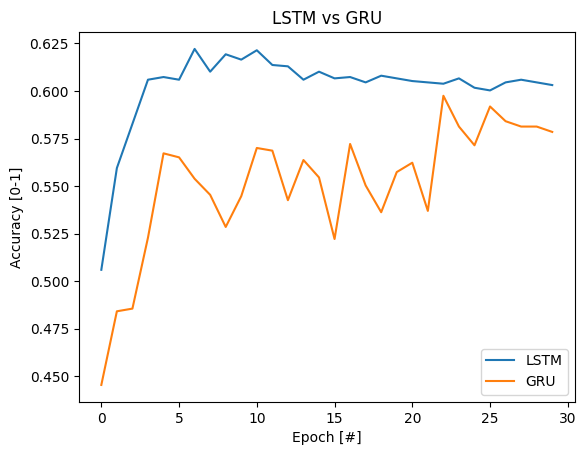

In [16]:
plt.plot(acc1, label="LSTM")
plt.plot(acc2, label="GRU")
plt.legend()
plt.xlabel("Epoch [#]")
plt.ylabel("Accuracy [0-1]")
plt.title("LSTM vs GRU")
plt.show()